In [197]:
import torch
import torchvision
import torchvision.transforms as transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [198]:
torch.cuda.is_available()

True

# Section 1 - Prepare data

Data is loaded from a video and split into frames

In [199]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations
transformation = Compose([
    Resize((64, 64)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(30),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensor()
])

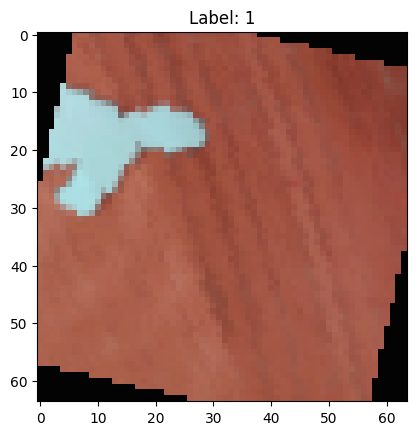

In [200]:
data_dir = "./dataset"
dataset = ImageFolder(root=data_dir, transform=transformation)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
img, l = None, None
for images, labels in data_loader:
    img, l = images[0], labels[0]
    break
img_test = img.permute(1, 2, 0).numpy()
plt.imshow(img_test)
plt.title(f"Label: {l}")
plt.show()


In [201]:
img.shape

torch.Size([3, 64, 64])

In [202]:
# HYPERPARAMETERS
test_len = 0.3
batch_size = 128
kernel_size = 3
stride = 1
padding = 1

In [203]:
from torch.utils.data import random_split

train_size = int((1-test_len) * len(dataset))
test_size = int(test_len * len(dataset))
extra = len(dataset) - (train_size + test_size)
train_size = train_size + extra if extra > 0 else train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) # no need to shuffle test data
device = "cuda" if torch.cuda.is_available() else "cpu"

In [204]:
# Define NN
from torch import nn

class VictimCNNModelV0(nn.Module):
    def __init__(self, input_channels, hidden_units, output_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*16*16,
                out_features=output_size)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [205]:
device

'cuda'

In [206]:
model = VictimCNNModelV0(3, 32, 1).to(device)

In [207]:
model.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[-1.8962e-01, -1.3134e-01, -9.8845e-02],
                        [-1.5502e-01,  1.3897e-01,  1.2935e-01],
                        [ 3.0584e-02,  1.3984e-01, -1.7877e-01]],
              
                       [[ 4.6591e-03,  1.6775e-02, -1.7925e-01],
                        [ 1.2536e-01,  8.6066e-04,  1.0743e-01],
                        [ 1.4628e-01, -1.5652e-01,  3.7433e-02]],
              
                       [[-1.9166e-01,  8.0288e-02, -1.4639e-01],
                        [ 1.2170e-01,  1.0975e-01, -1.2151e-01],
                        [-1.5501e-01,  1.6553e-01,  1.0043e-01]]],
              
              
                      [[[-6.7527e-02,  5.9868e-02, -4.7826e-02],
                        [ 1.5911e-01, -1.5913e-03,  7.9924e-02],
                        [-1.5787e-01, -1.8709e-01, -1.8551e-01]],
              
                       [[-1.6291e-01, -7.9647e-02, -1.3177e-01],
                        [ 1.1060e-01, -7.62

In [208]:
# Find image dimensions for linear layer
model(img.unsqueeze(0).to(device))

tensor([[0.7408]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [209]:
from torchmetrics import Accuracy
def train_epoch(model,data_loader,loss_fn,optimizer,device):
    train_loss, train_acc = 0,0
    accuracy = Accuracy(task="binary").to(device)
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X).squeeze(1)
        batch_loss = loss_fn(y_pred, y.float())
        train_loss += batch_loss
        y_pred = (y_pred > 0.5).long()
        train_acc += accuracy(y_pred, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_epoch(model,data_loader,loss,optimizer,device):
  test_loss, test_acc = 0, 0
  model.eval()
  accuracy = Accuracy(task="binary").to(device)
  with torch.inference_mode():
    for X,y in test_dataloader:
      X,y = X.to(device), y.unsqueeze(1).to(device)
      test_pred = model(X)
      test_loss += loss(test_pred,y.float())
      test_pred = (test_pred > 0.5).long()
      test_acc +=  accuracy(test_pred, y)
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
  print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.2f}% \n")


In [210]:
from tqdm.auto import tqdm

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3

for i in tqdm(range(epochs)):
    print(f"Epoch {i+1}\n-------------------------------")
    train_epoch(model, train_dataloader, loss, optimizer, device)
    test_epoch(model, test_dataloader, loss, optimizer, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 0.14822 | Train acc: 0.94%

Test loss: 0.0674, Test acc: 0.96% 

Epoch 2
-------------------------------
Train loss: 0.03782 | Train acc: 0.98%

Test loss: 0.0291, Test acc: 0.99% 

Epoch 3
-------------------------------
Train loss: 0.04921 | Train acc: 0.98%

Test loss: 0.0692, Test acc: 0.97% 


In [211]:
img, l = None, None
for images, labels in train_dataloader:
    img, l = images[0], labels[0]
    break

for batch, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)

    break

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [212]:
torch.save(model.state_dict(), 'first_cnn.pth')

In [213]:
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device

VictimCNNModelV0(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flat

Actual class: 0 | Predicted class: [0]


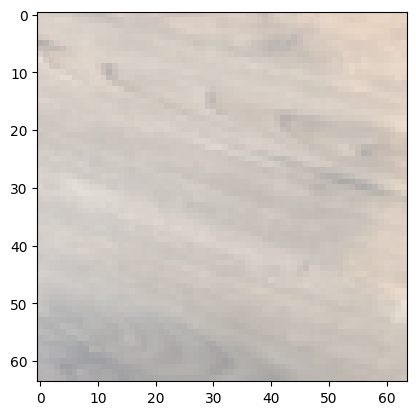

Actual class: 1 | Predicted class: [1]


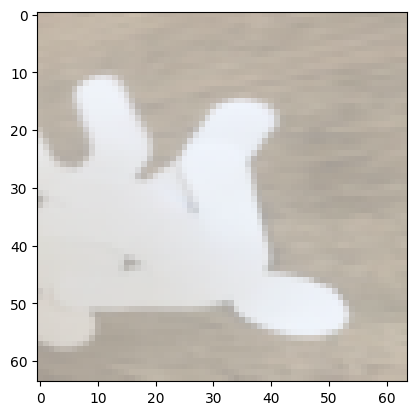

Actual class: 1 | Predicted class: [1]


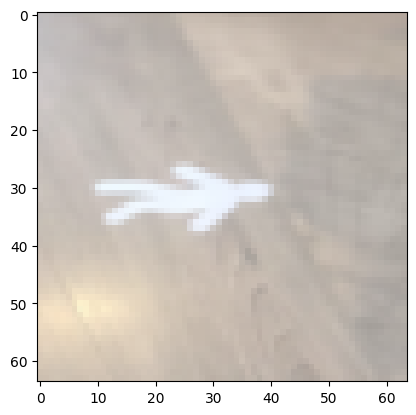

Actual class: 1 | Predicted class: [1]


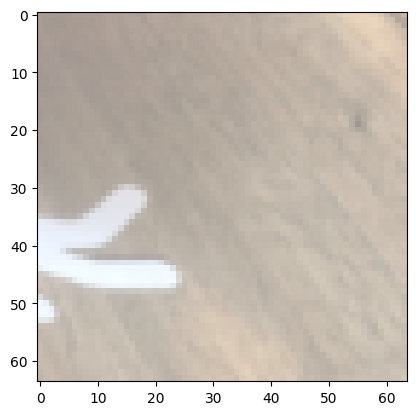

In [214]:
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the transformation
transformation = Compose([
    Resize((64, 64)),
    ToTensor()
])

# Load the images from the test folder
test_data_dir = "./test"  # Replace with your test folder path
test_dataset = ImageFolder(root=test_data_dir, transform=transformation)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Load the trained model
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device
model.eval()  # Set the model to evaluation mode


# Define a function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Predict the labels for the test images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = torch.sigmoid(model(images))
    predicted = (outputs > 0.5).long()
    
    # Convert tensors to numpy arrays for visualization
    predicted_np = predicted.cpu().numpy()
    labels_np = labels.numpy()
    
    # Plot the images and display the actual and predicted classes
    for i in range(len(images)):
        print(f"Actual class: {labels_np[i]} | Predicted class: {predicted_np[i]}")
        imshow(images[i].cpu())